In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
## savgol filter ##
def SG_fil(data,window,column_name,order=2):
    df = data.copy()
    for n in column_name:
        df[n] = savgol_filter(df.loc[:,n],window,order)
    return df

def lumin2cogload(lumin):
    # coeff_left = [2.451072052, -15.47037207, 2.49154129]
    # coeff_right = [2.489320955, -13.62467234, 2.540344354]
    coeff_left = [1.326173, -4.42176, 3.016348]
    coeff_right = [1.225595, -5.16006, 3.3087083]
    cogload_adjust_left = coeff_left[0]*np.exp(coeff_left[1]*lumin) + coeff_left[2]
    cogload_adjust_right = coeff_right[0]*np.exp(coeff_right[1]*lumin) + coeff_right[2]
    return cogload_adjust_left, cogload_adjust_right

In [8]:
path = '../data/test/'

data_raw = []
data_analysis = pd.DataFrame()

PVC_1_target = np.array([0.5,0.85,0.35])
Alu_1_target = np.array([0.2,0.85,0.35])
Cas_1_target = np.array([0.8,0.85,0.35])
PVC_2_target = np.array([0.2,0.5,0.35])
Alu_2_target = np.array([0.5,0.5,0.35])
Cas_2_target = np.array([0.8,0.5,0.35])

for home, dirs, files in os.walk(path):
        for filename in files:
                t = pd.read_csv(home+"/"+filename,index_col=0)
                t = t[90:-1].reset_index()
                t[["participant_id"]] = filename[1:3]
                participant_id = filename[1:3]
                t[["condition"]] = filename[4:8]
                condition = filename[4:8]

                t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
                t['RightPupilD'][t['RightPupilD']<0] = np.nan
                t[['LeftPupilD','RightPupilD']] = t[['LeftPupilD','RightPupilD']].interpolate(method='linear',axis=0,limit_direction ='both')
                t = SG_fil(t,41,['LeftPupilD','RightPupilD','Lumin'])

                (t[['cogload_adjust_left']], t[['cogload_adjust_right']]) = lumin2cogload(t[['Lumin']])
                t[['cogload_left']] = t[['LeftPupilD']].values - t[['cogload_adjust_left']].values
                t[['cogload_right']] = t[['RightPupilD']].values - t[['cogload_adjust_right']].values

                cogload_left = t["cogload_left"].mean()
                cogload_right = t["cogload_right"].mean()
                cogload = (cogload_left + cogload_right)/2
                time_all = len(t)/90

                mission_group = t.groupby('pickupName')
                mission_Alu_1 = mission_group.get_group('Pipe Aluminum 1')
                Alu_1_end = mission_Alu_1.iloc[-1][['Cube2X','Cube2Y','Cube2Z']].values
                Alu_1_time = mission_Alu_1.index[-1] - mission_Alu_1.index[0]
                mission_Alu_2 = mission_group.get_group('Pipe Aluminum 2')
                Alu_2_end = mission_Alu_2.iloc[-1][['Cube5X','Cube5Y','Cube5Z']].values
                Alu_2_time = mission_Alu_2.index[-1] - mission_Alu_2.index[0]
                mission_Cas_1 = mission_group.get_group('Pipe Cast-Iron 1')
                Cas_1_end = mission_Cas_1.iloc[-1][['Cube3X','Cube3Y','Cube3Z']].values
                Cas_1_time = mission_Cas_1.index[-1] - mission_Cas_1.index[0]
                mission_Cas_2 = mission_group.get_group('Pipe Cast-Iron 2')
                Cas_2_end = mission_Cas_2.iloc[-1][['Cube6X','Cube6Y','Cube6Z']].values
                Cas_2_time = mission_Cas_2.index[-1] - mission_Cas_2.index[0]
                mission_PVC_1 = mission_group.get_group('Pipe PVC 1')
                PVC_1_end = mission_PVC_1.iloc[-1][['Cube1X','Cube1Y','Cube1Z']].values
                PVC_1_time = mission_PVC_1.index[-1] - mission_PVC_1.index[0]
                mission_PVC_2 = mission_group.get_group('Pipe PVC 2')
                PVC_2_end = mission_PVC_2.iloc[-1][['Cube4X','Cube4Y','Cube4Z']].values
                PVC_2_time = mission_PVC_2.index[-1] - mission_PVC_2.index[0]

                collider_group = t.groupby('MeshCollider')
                collision_times = len(collider_group.groups)
                deformation_group = t.groupby('MeshDeformation')
                deformation_times = len(deformation_group.groups)

                Alu_1_R_accuracy = np.sqrt(np.power(Alu_1_end[0]-Alu_1_target[0],2) + np.power(Alu_1_end[1]-Alu_1_target[1],2))
                Alu_2_R_accuracy = np.sqrt(np.power(Alu_2_end[0]-Alu_2_target[0],2) + np.power(Alu_2_end[1]-Alu_2_target[1],2))
                PVC_1_R_accuracy = np.sqrt(np.power(PVC_1_end[0]-PVC_1_target[0],2) + np.power(PVC_1_end[1]-PVC_1_target[1],2))
                PVC_2_R_accuracy = np.sqrt(np.power(PVC_2_end[0]-PVC_2_target[0],2) + np.power(PVC_2_end[1]-PVC_2_target[1],2))
                Cas_1_R_accuracy = np.sqrt(np.power(Cas_1_end[0]-Cas_1_target[0],2) + np.power(Cas_1_end[1]-Cas_1_target[1],2))
                Cas_2_R_accuracy = np.sqrt(np.power(Cas_2_end[0]-Cas_2_target[0],2) + np.power(Cas_2_end[1]-Cas_2_target[1],2))

                Alu_1_D_accuracy = np.abs(Alu_1_end[2] - Alu_1_target[2])
                Alu_2_D_accuracy = np.abs(Alu_2_end[2] - Alu_2_target[2])
                PVC_1_D_accuracy = np.abs(PVC_1_end[2] - PVC_1_target[2])
                PVC_2_D_accuracy = np.abs(PVC_2_end[2] - PVC_2_target[2])
                Cas_1_D_accuracy = np.abs(Cas_1_end[2] - Cas_1_target[2])
                Cas_2_D_accuracy = np.abs(Cas_2_end[2] - Cas_2_target[2])


                threshold = 0.3
                if Alu_1_R_accuracy>threshold:
                        Alu_1_R_accuracy = data_analysis["Alu_1_R_accuracy"].max()
                if Alu_2_R_accuracy>threshold:
                        Alu_2_R_accuracy = data_analysis["Alu_2_R_accuracy"].max()
                if PVC_1_R_accuracy>threshold:
                        PVC_1_R_accuracy = data_analysis["PVC_1_R_accuracy"].max()
                if PVC_2_R_accuracy>threshold:
                        PVC_2_R_accuracy = data_analysis["PVC_2_R_accuracy"].max()
                if Cas_1_R_accuracy>threshold:
                        Cas_1_R_accuracy = data_analysis["Cas_1_R_accuracy"].max()
                if Cas_2_R_accuracy>threshold:
                        Cas_2_R_accuracy = data_analysis["Cas_2_R_accuracy"].max()

                if Alu_1_D_accuracy>threshold:
                        Alu_1_D_accuracy = data_analysis["Alu_1_D_accuracy"].max()
                if Alu_2_D_accuracy>threshold:
                        Alu_2_D_accuracy = data_analysis["Alu_2_D_accuracy"].max()
                if PVC_1_D_accuracy>threshold:
                        PVC_1_D_accuracy = data_analysis["PVC_1_D_accuracy"].max()
                if PVC_2_D_accuracy>threshold:
                        PVC_2_D_accuracy = data_analysis["PVC_2_D_accuracy"].max()
                if Cas_1_D_accuracy>threshold:
                        Cas_1_D_accuracy = data_analysis["Cas_1_D_accuracy"].max()
                if Cas_2_D_accuracy>threshold:
                        Cas_2_D_accuracy = data_analysis["Cas_2_D_accuracy"].max()

                total_R_accuracy = Alu_1_R_accuracy + Alu_2_R_accuracy + PVC_1_R_accuracy + PVC_2_R_accuracy + Cas_1_R_accuracy + Cas_2_R_accuracy
                total_D_accuracy = Alu_1_D_accuracy + Alu_2_D_accuracy + PVC_1_D_accuracy + PVC_2_D_accuracy + Cas_1_D_accuracy + Cas_2_D_accuracy


                data_analysis = data_analysis.append(pd.DataFrame([[condition,participant_id,time_all,cogload,collision_times,deformation_times,total_R_accuracy,total_D_accuracy,
                                                                Alu_1_time,Alu_2_time,Cas_1_time,Cas_2_time,PVC_1_time,PVC_2_time,
                                                                Alu_1_R_accuracy,Alu_2_R_accuracy,PVC_1_R_accuracy,PVC_2_R_accuracy,Cas_1_R_accuracy,Cas_2_R_accuracy,
                                                                Alu_1_D_accuracy,Alu_2_D_accuracy,PVC_1_D_accuracy,PVC_2_D_accuracy,Cas_1_D_accuracy,Cas_2_D_accuracy,
                                                                ]],
                                                columns=["condition","participant_id","time_all","cogload","collision_times","deformation_times","total_R_accuracy","total_D_accuracy",
                                                        "Alu_1_time","Alu_2_time","Cas_1_time","Cas_2_time","PVC_1_time","PVC_2_time",
                                                        "Alu_1_R_accuracy","Alu_2_R_accuracy","PVC_1_R_accuracy","PVC_2_R_accuracy","Cas_1_R_accuracy","Cas_2_R_accuracy",
                                                        "Alu_1_D_accuracy","Alu_2_D_accuracy","PVC_1_D_accuracy","PVC_2_D_accuracy","Cas_1_D_accuracy","Cas_2_D_accuracy",
                                                        ]),
                                                ignore_index=True)

data_analysis[['collision_times','deformation_times']] = data_analysis[['collision_times','deformation_times']].astype(float)

C:\Users\Du-Lab\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-8-d479468466dc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-8-d479468466dc>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['RightPupilD'][t['RightPupilD']<0] = np.nan
<ipython-input-8-d479468466dc>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [9]:
data_analysis

,condition,participant_id,time_all,cogload,collision_times,deformation_times,total_R_accuracy,total_D_accuracy,Alu_1_time,Alu_2_time,...,PVC_1_R_accuracy,PVC_2_R_accuracy,Cas_1_R_accuracy,Cas_2_R_accuracy,Alu_1_D_accuracy,Alu_2_D_accuracy,PVC_1_D_accuracy,PVC_2_D_accuracy,Cas_1_D_accuracy,Cas_2_D_accuracy
0,Cont,01,118.733333,0.317663,6.0,3.0,0.109424,0.347274,627,2411,...,0.009306,0.032516,0.007547,0.028598,0.022919,0.086384,0.064005,0.009044,0.096608,0.068314
1,Hapt,01,145.077778,0.322410,0.0,0.0,0.064553,0.131511,1189,1781,...,0.009770,0.010086,0.011324,0.011477,0.013230,0.012197,0.078089,0.011504,0.008892,0.007599
2,Mult,01,133.255556,0.174430,0.0,0.0,0.064181,0.064120,961,1670,...,0.009958,0.009844,0.012520,0.011388,0.014018,0.009724,0.004654,0.013845,0.001587,0.020292
3,Visu,01,103.011111,0.039178,4.0,1.0,0.109672,0.319550,1087,1135,...,0.011383,0.013158,0.044340,0.012942,0.048808,0.058390,0.059841,0.070566,0.052965,0.028980
4,Cont,02,132.611111,-0.602542,4.0,5.0,0.239115,0.247424,885,1298,...,0.027436,0.017729,0.070777,0.024512,0.009159,0.047009,0.035219,0.009958,0.040109,0.105969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,Visu,30,121.111111,0.331397,4.0,0.0,0.255448,0.486499,671,223,...,0.016202,0.005909,0.010886,0.080126,0.066869,0.177161,0.059037,0.041418,0.116727,0.025286
120,Cont,31,108.933333,-0.272361,5.0,3.0,0.173536,0.322734,960,1513,...,0.018522,0.052360,0.049344,0.020349,0.063855,0.073930,0.021073,0.019828,0.090039,0.054009
121,Hapt,31,123.255556,-0.074288,0.0,0.0,0.076308,0.013688,1067,1190,...,0.010607,0.009597,0.016503,0.010173,0.004519,0.001889,0.000165,0.000190,0.003975,0.002950
122,Mult,31,103.833333,-0.287623,0.0,0.0,0.075863,0.027911,1073,895,...,0.009748,0.013948,0.015889,0.009640,0.004154,0.001989,0.000856,0.000230,0.011763,0.008918


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Cont v.s. Visu: Wilcoxon test (paired samples), P_val=1.147e-02 stat=1.190e+02
Using zero_method  wilcox
Visu v.s. Hapt: Wilcoxon test (paired samples), P_val=4.209e-05 stat=3.900e+01
Using zero_method  wilcox
Hapt v.s. Mult: Wilcoxon test (paired samples), P_val=2.114e-05 stat=3.100e+01
Using zero_method  wilcox
Cont v.s. Hapt: Wilcoxon test (paired samples), P_val=2.478e-04 stat=6.100e+01
Using zero_method  wilcox
Visu v.s. Mult: Wilcoxon test (paired samples), P_val=4.105e-01 stat=2.060e+02
Using zero_method  wilcox
Cont v.s. Mult: Wilcoxon test (paired samples), P_val=1.510e-02 stat=1.240e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Cont v.s. Visu: 

Text(1715.6521739130435, 0.5, 'Total Depth Error')

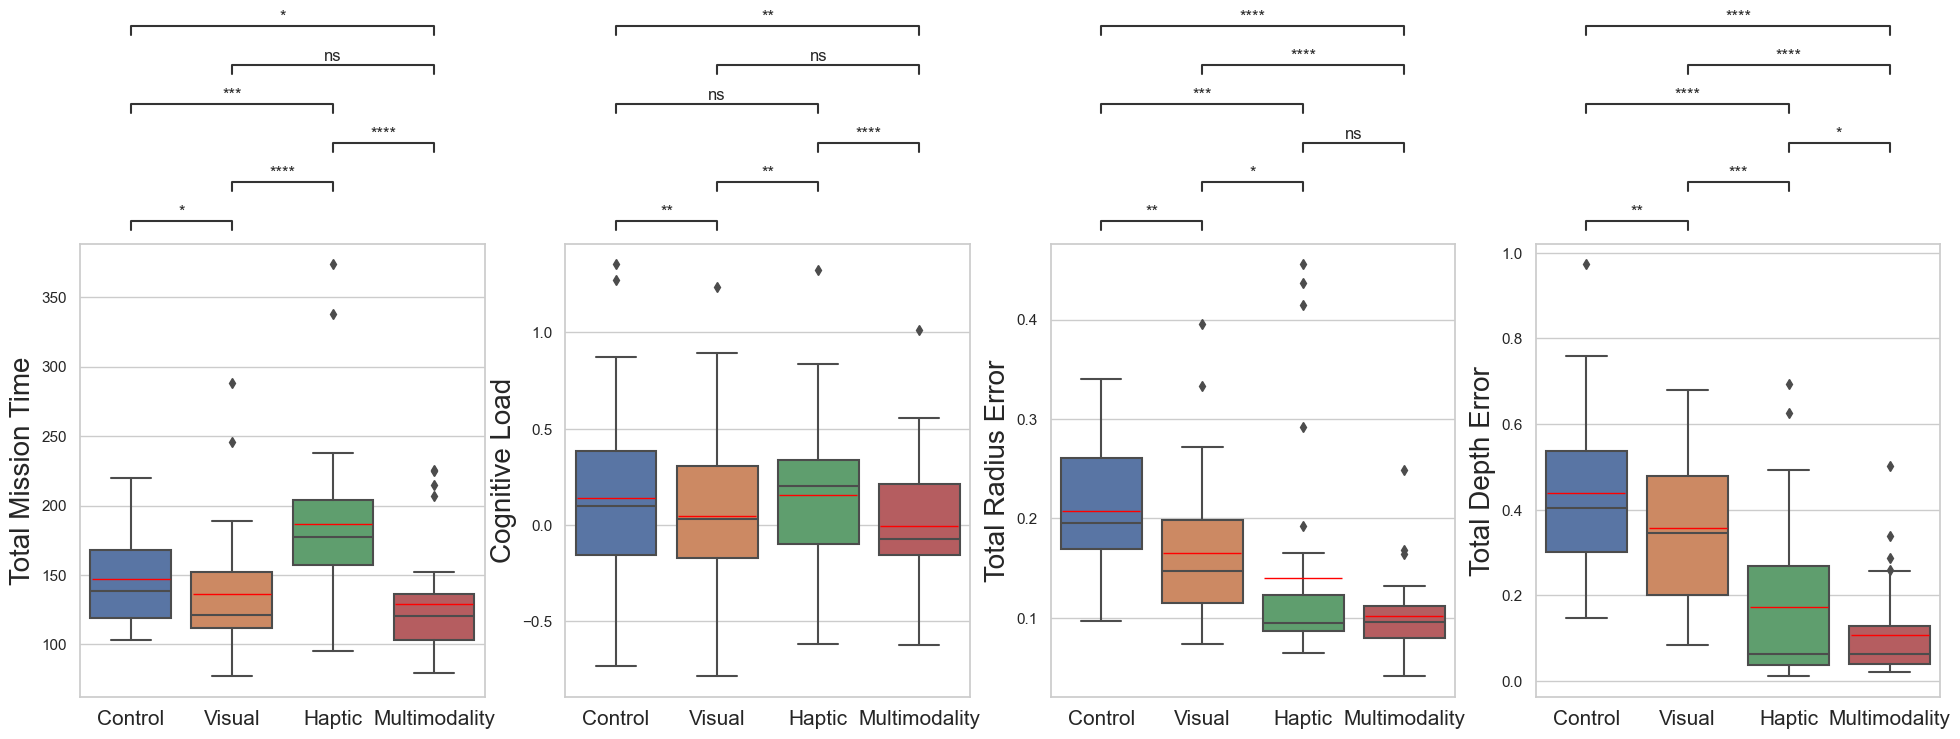

In [11]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
# y_list = ["collision_times","deformation_times","total_R_accuracy","total_D_accuracy"]; y_name = ['Collision Times','Deformation Times','Total Radius Error','Total Depth Error']
y_list = ["time_all","cogload","total_R_accuracy","total_D_accuracy"]; y_name = ['Total Mission Time','Cognitive Load','Total Radius Error','Total Depth Error']
order = ["Cont","Visu","Hapt","Mult"]; xticks = ["Control","Visual","Haptic","Multimodality"]
method = 'Wilcoxon'
# method = 'Kruskal'
data = data_analysis
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         (order[0], order[3]),
         (order[1], order[2]),
         (order[1], order[3]),
         (order[2], order[3]),
            ]

average_line_length = "56" #76

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[0].set_xticklabels(xticks, fontsize=15)
axes[0].set_xlabel('', fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)


y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[1].set_xticklabels(xticks, fontsize=15)
axes[1].set_xlabel('', fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set_xticklabels(xticks, fontsize=15)
axes[2].set_xlabel('', fontsize = 20)
axes[2].set_ylabel(y_name[2], fontsize = 20)


y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set_xticklabels(xticks, fontsize=15)
axes[3].set_xlabel('', fontsize = 20)
axes[3].set_ylabel(y_name[3], fontsize = 20)

In [1]:
# Survey

In [12]:
information_raw = pd.read_csv("../data/questionnaire/Personal Info - Pipe Insertion.csv")
nasatlx_raw = pd.read_csv("../data/questionnaire/NASA TLX - Pipe Insertion.csv")
sart_raw = pd.read_csv("../data/questionnaire/SART - Pipe Insertion.csv")
trust_raw = pd.read_csv("../data/questionnaire/Trust Survey - Pipe Insertion.csv")

for i in nasatlx_raw,sart_raw,trust_raw:
    int_cols = i.select_dtypes(include=['int64'])
    i[int_cols.columns] = int_cols.astype(float)

In [16]:
nasatlx_raw['total']= nasatlx_raw.iloc[:,3]+nasatlx_raw.iloc[:,4]+nasatlx_raw.iloc[:,5]+nasatlx_raw.iloc[:,6]\
                    +nasatlx_raw.iloc[:,7]+nasatlx_raw.iloc[:,8]
sart_raw['total']= sart_raw.iloc[:,3]+sart_raw.iloc[:,4]+sart_raw.iloc[:,5]+sart_raw.iloc[:,6]\
                    +sart_raw.iloc[:,7]+sart_raw.iloc[:,8]+sart_raw.iloc[:,9]+sart_raw.iloc[:,10]
trust_raw['total']= trust_raw.iloc[:,3]+trust_raw.iloc[:,4]+trust_raw.iloc[:,5]+trust_raw.iloc[:,6]\
                    +trust_raw.iloc[:,7]+trust_raw.iloc[:,8]                    

In [17]:
nasatlx_raw

,Timestamp,Participant serial number,Conditions,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,total
0,2022/11/21 4:02:01 PM EST,1.0,Multi Augmented Condition,1.0,2.0,2.0,2.0,2.0,1.0,10.0
1,2022/11/21 4:14:32 PM EST,1.0,Haptic Augmented Condition,3.0,3.0,2.0,2.0,3.0,2.0,15.0
2,2022/11/21 4:22:02 PM EST,1.0,Visual Augmented Condition,5.0,4.0,2.0,8.0,6.0,3.0,28.0
3,2022/11/21 4:25:45 PM EST,1.0,Control Condition,8.0,7.0,4.0,10.0,8.0,7.0,44.0
4,2022/11/29 5:45:37 PM EST,2.0,Multi Augmented Condition,2.0,2.0,1.0,2.0,2.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...
115,2022/12/09 5:55:55 PM EST,29.0,Haptic Augmented Condition,8.0,10.0,9.0,6.0,8.0,8.0,49.0
116,2022/12/10 12:20:44 PM EST,30.0,Visual Augmented Condition,8.0,3.0,3.0,6.0,8.0,10.0,38.0
117,2022/12/10 12:25:06 PM EST,30.0,Control Condition,8.0,4.0,3.0,9.0,6.0,9.0,39.0
118,2022/12/10 12:32:01 PM EST,30.0,Haptic Augmented Condition,8.0,5.0,2.0,8.0,7.0,9.0,39.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Control Condition v.s. Visual Augmented Condition: Wilcoxon test (paired samples), P_val=6.572e-04 stat=6.700e+01
Using zero_method  wilcox
Visual Augmented Condition v.s. Haptic Augmented Condition: Wilcoxon test (paired samples), P_val=3.676e-01 stat=1.635e+02
Using zero_method  wilcox
Haptic Augmented Condition v.s. Multi Augmented Condition: Wilcoxon test (paired samples), P_val=9.723e-06 stat=1.300e+01
Using zero_method  wilcox
Control Condition v.s. Haptic Augmented Condition: Wilcoxon test (paired samples), P_val=9.400e-02 stat=1.295e+02
Using zero_method  wilcox
Visual Augmented Condition v.s. Multi Augmented Condition: Wilcoxon test (paired samples), P_val=3.164e-04 stat=5.750e+01
Using zero_method  wilcox
Control Condition v.s. Multi Augmented Condition: Wilcoxon test (paired samples), P_v

Text(1234.684782608696, 0.5, 'Trust Level')

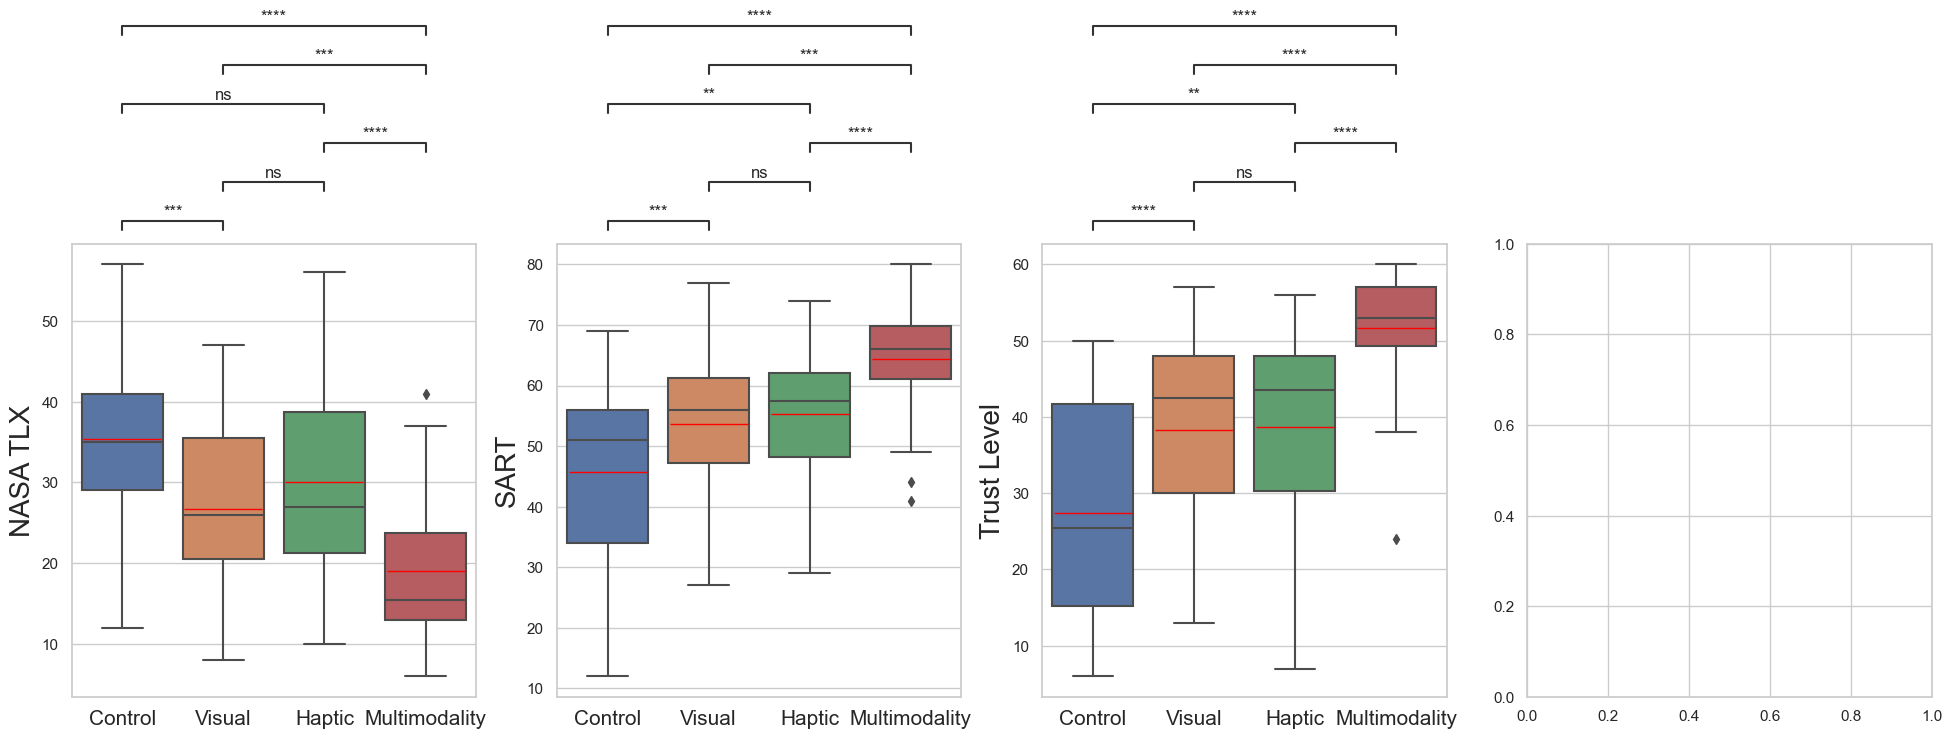

In [19]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'Conditions'
y_list = ["total","total","total"]; y_name = ['NASA TLX','SART','Trust Level']
order = ["Control Condition","Visual Augmented Condition","Haptic Augmented Condition","Multi Augmented Condition"]; xticks = ["Control","Visual","Haptic","Multimodality"]
method = 'Wilcoxon'
# method = 'Kruskal'
data_list = [nasatlx_raw,sart_raw,trust_raw]
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         (order[0], order[3]),
         (order[1], order[2]),
         (order[1], order[3]),
         (order[2], order[3]),
            ]

average_line_length = "56" #76

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data_list[0], x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data_list[0], x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[0].set_xticklabels(xticks, fontsize=15)
axes[0].set_xlabel('', fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)


y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data_list[1], x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data_list[1], x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[1].set_xticklabels(xticks, fontsize=15)
axes[1].set_xlabel('', fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data_list[2], x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data_list[2], x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set_xticklabels(xticks, fontsize=15)
axes[2].set_xlabel('', fontsize = 20)
axes[2].set_ylabel(y_name[2], fontsize = 20)


# y = y_list[3]
# axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
#                                  box_pairs=box_pairs,
#                                  test=method, 
#                                  comparisons_correction=None, 
#                                  text_format='star', loc='outside', verbose=1,
#                                  # stats_params={'alternative': 'greater'}
#                                  )
# axes[3].set_xticklabels(xticks, fontsize=15)
# axes[3].set_xlabel('', fontsize = 20)
# axes[3].set_ylabel(y_name[3], fontsize = 20)